In [1]:
!pip install pymongo pandas scikit-learn matplotlib

In [2]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client['store']

In [7]:
import pymongo
import pandas as pd

# Connect to MongoDB and fetch profiling data
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['store']

# Fetch profiling data
profile_data = list(db.system.profile.find().sort("ts", -1))

# Convert to pandas DataFrame
df = pd.DataFrame(profile_data)

# Save to CSV
df.to_csv("query_performance_logs.csv", index=False)

In [8]:
# Extract query length from the 'command' field
df['query_length'] = df['command'].apply(lambda x: len(str(x).split()))

# Used index (if keysExamined is greater than 0, an index was used)
df['used_index'] = df['keysExamined'].apply(lambda x: 1 if x > 0 else 0)

# Other features like 'nscanned', 'nreturned', and 'millis'
features = df[['query_length', 'used_index', 'docsExamined', 'nreturned', 'millis']]

# Display the processed features
features.head()

,query_length,used_index,docsExamined,nreturned,millis
0,13,0,8.0,8.0,0
1,13,0,7.0,7.0,0
2,13,0,6.0,6.0,0
3,13,0,5.0,5.0,0
4,15,0,4.0,4.0,0


#### Essential features ready (query_length, used_index, docsExamined, nreturned, and millis) to train the machine learning model to predict query performance (execution time).

In [9]:
# Fill missing values (NaNs) with zeros
features = features.fillna(0)

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib

# Load your data (replace with your actual data loading logic)
df = pd.read_csv("query_performance_logs.csv")  # or another data source

# Feature engineering
df['query_length'] = df['command'].apply(lambda x: len(str(x).split()))
df['used_index'] = df['keysExamined'].apply(lambda x: 1 if x > 0 else 0)
df.fillna(0, inplace=True)  # Handle missing values

# Prepare features and target
X = df[['query_length', 'used_index', 'docsExamined', 'nreturned']]
y = df['millis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model with scaled features
model = RandomForestRegressor()

print("Training the model...")
model.fit(X_train_scaled, y_train)
print("Model trained successfully.")

# Make predictions
predictions = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Save the trained model and scaler
joblib.dump(model, 'random_forest_model.pkl')  # Save the model
joblib.dump(scaler, 'scaler.pkl')               # Save the scaler

Training the model...
Model trained successfully.
Mean Squared Error: 12.801799999999998


['scaler.pkl']

#### A Mean Squared Error (MSE) of 12.80 is a significant improvement, showing that the model is now making much smaller errors in its predictions

In [24]:
# Get feature importances
importances = model.feature_importances_
feature_names = ['query_length', 'used_index', 'docsExamined', 'nreturned']

# Display feature importances
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance}")

query_length: 0.310525086755261
used_index: 0.0
docsExamined: 0.42512658716332874
nreturned: 0.26434832608141023


#### The feature importance scores listed indicate how much each feature contributes to the model’s performance in predicting query execution time.


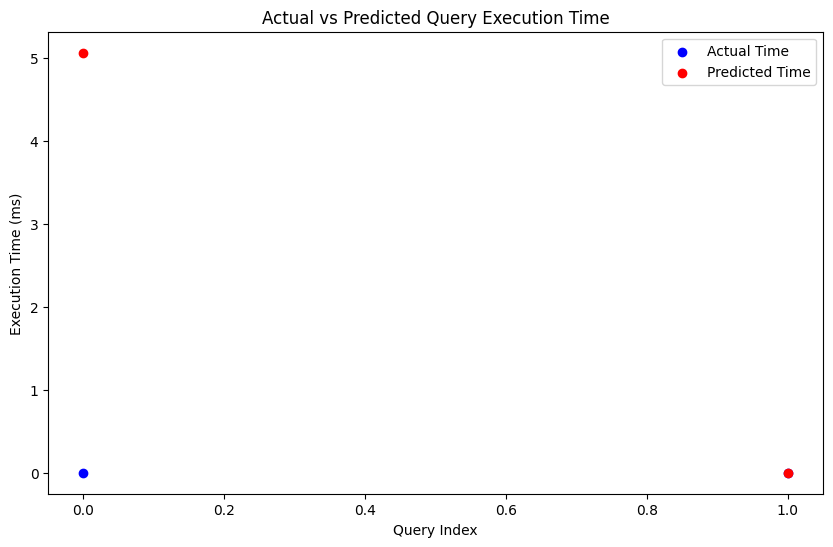

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Time', color='blue')
plt.scatter(range(len(predictions)), predictions, label='Predicted Time', color='red')
plt.xlabel('Query Index')
plt.ylabel('Execution Time (ms)')
plt.title('Actual vs Predicted Query Execution Time')
plt.legend()
plt.show()

#### More the execution time, more is need to optimize your query.

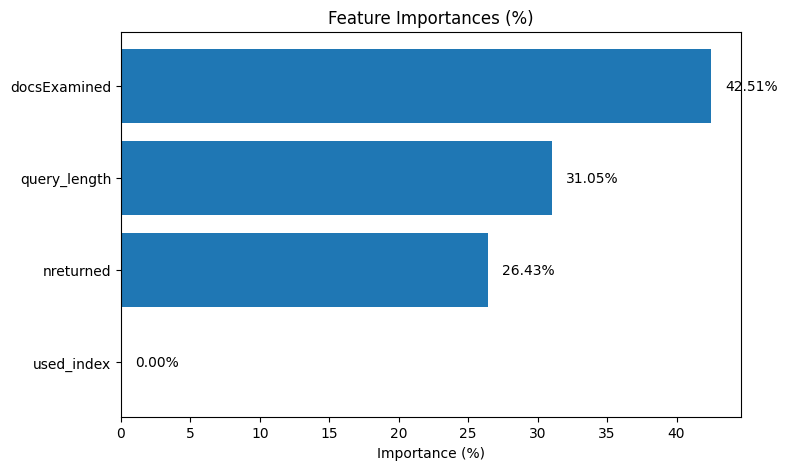

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `importances` contains the feature importances from your trained model
# and `feature_names` is a list of the corresponding feature names.
importances = model.feature_importances_  # Get feature importances from your model
feature_names = ['query_length', 'used_index', 'docsExamined', 'nreturned']

# Convert importances to percentage
importances_percentage = importances * 100

# Plot feature importance
plt.figure(figsize=(8, 5))
indices = np.argsort(importances_percentage)  # Get the indices of the sorted importances

plt.title('Feature Importances (%)')
bars = plt.barh(range(len(indices)), importances_percentage[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance (%)')

# Annotate each bar with the percentage value
for bar in bars:
    width = bar.get_width()  # Get the width of the bar
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', 
             va='center')  # Add text annotation next to the bar

plt.show()

In [29]:
import streamlit as st
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Streamlit app
st.title('AI-Powered Query Optimization')

# User inputs (for simplicity, we're hardcoding query features here)
query_length = st.slider('Query Length', 1, 50, 10)
used_index = st.selectbox('Used Index', [0, 1])
docs_examined = st.slider('Documents Examined', 1, 10000, 1000)
nreturned = st.slider('Documents Returned', 1, 5000, 500)

# Load trained model (replace with your trained model)
model = RandomForestRegressor()

print("Training the model...")
model.fit(X_train_scaled, y_train)
print("Model trained successfully.")

# Make prediction
input_data = [[query_length, used_index, docs_examined, nreturned]]
scaled_data = scaler.transform(input_data)  # Assuming you've scaled the data
prediction = model.predict(scaled_data)

st.write(f'Predicted Query Execution Time: {prediction[0]} ms')

2024-10-11 17:34:46.768 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 17:34:46.769 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 17:34:46.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 17:34:46.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 17:34:46.773 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 17:34:46.774 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 17:34:46.775 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 17:34:46.776 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Training the model...
Model trained successfully.


In [47]:
from pymongo import MongoClient
import joblib
import numpy as np
import time

# Load the trained model and scaler
model = joblib.load('random_forest_model.pkl')  # Load your trained model
scaler = joblib.load('scaler.pkl')  # Load your scaler

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['store']  # Replace with your actual database name
collection = db['orders']  # Assuming your collection is named 'orders'

def run_query_and_predict(query):
    # Execute the query and measure its execution time
    start_time = time.time()  # Start timing the query execution
    result = collection.find(query).sort("order_date", -1)  # Sort by order_date in descending order
    execution_time = time.time() - start_time  # Calculate execution time
    
    # Extract execution metrics
    query_length = len(str(query))  # Length of the query as a feature
    used_index = 1 if 'customer_id' in str(query) else 0  # Check if an index is used
    docs_examined = collection.count_documents(query)  # Number of documents examined
    nreturned = len(list(result))  # Number of documents returned

    # Prepare input data for prediction
    input_data = [[query_length, used_index, docs_examined, nreturned]]
    scaled_data = scaler.transform(input_data)  # Scale the data
    predicted_time = model.predict(scaled_data)  # Get the prediction
    
    # Generate suggestions based on predicted execution time
    suggestions = []
    if predicted_time[0] > 5:  # Threshold for execution time in ms
        suggestions.append("Consider adding an index to improve query performance.")
    if docs_examined > 100:  # Threshold for examined documents
        suggestions.append("Try to limit the number of documents examined by refining your query.")
    if query_length > 50:  # Threshold for query length
        suggestions.append("Optimize the query structure to reduce its length.")

    return predicted_time[0], suggestions

# Define the query to run
query = {
    "customer_id": "123"  # Replace with an actual customer ID
}

# Run the query and get predictions
predicted_time, suggestions = run_query_and_predict(query)

# Print the results
print(f"Predicted execution time: {predicted_time:.2f} ms")
print("Suggestions:")
for suggestion in suggestions:
    print(f"- {suggestion}")


Predicted execution time: 5.87 ms
Suggestions:
- Consider adding an index to improve query performance.


C:\Users\vaibh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
